<a href="https://colab.research.google.com/github/felixzhao/stat501-project/blob/main/notebooks/1_0_MK_joined_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython

In [2]:
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%%R
library(readxl)
user_data <- read_excel("/content/drive/MyDrive/csv/Stats Consulting Data.xlsx", sheet="user_data")
start_end_registrations <- read_excel("/content/drive/MyDrive/csv/Stats Consulting Data.xlsx", sheet="start_end_registrations")
intervention_history <- read_excel("/content/drive/MyDrive/csv/Stats Consulting Data.xlsx", sheet="intervention_history")
onboarding_medical_data <- read_excel("/content/drive/MyDrive/csv/Stats Consulting Data.xlsx", sheet="onboarding_medical_data")
weight_milestones <- read_excel("/content/drive/MyDrive/csv/Stats Consulting Data.xlsx", sheet="weight_milestones")
onboarding_status <- read_excel("/content/drive/MyDrive/csv/Stats Consulting Data.xlsx", sheet="onboarding_status")
citizen_advisor_view <- read_excel("/content/drive/MyDrive/csv/Stats Consulting Data.xlsx", sheet="citizen_advisor_view")

This chunk of code converts the data to wide format and calculates the number of goals set for each individual.

In [9]:
%%R
library(tidyr)
library(tidyverse)

wide_SER <- pivot_wider(start_end_registrations,
            id_cols="citizenId",
            names_from="type",
            values_from = "valueCount")

wide_SER$goalsSet <- rowSums(!is.na(wide_SER))

# intervention_history

This chunk of code is to just get an idea of the response rates. I made a histogram of all the responses.

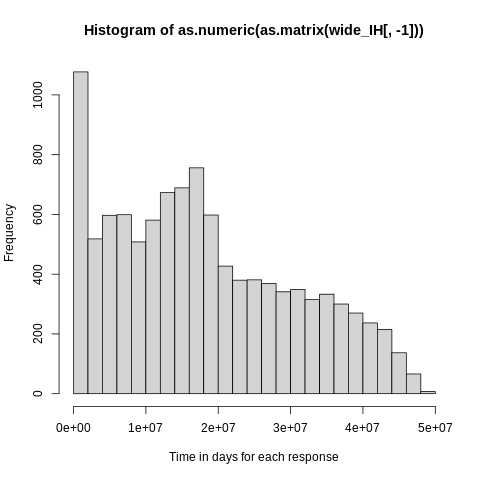

In [11]:
%%R
library(lubridate)

# Make data into wide format and remove the Id column
wide_IH <- pivot_wider(intervention_history,
            id_cols="citizenId",
            names_from="interventionNumber",
            values_from = "interventionDate")
wide_IH <- wide_IH %>% remove_rownames %>% column_to_rownames(var="citizenId")

# Convert each column to numeric (system seconds)
for(column in 1:ncol(wide_IH)) {
  wide_IH[,column] <- as.numeric(wide_IH[,column])
}

# Calculate the time since the initial response then set initial response to 0
wide_IH[,2:ncol(wide_IH)] <- (wide_IH[,2:ncol(wide_IH)] - wide_IH[,1])
wide_IH[,1] <- 0

# Make a histogram of the responses since their inital response (without including the very first one)
hist(as.numeric(as.matrix(wide_IH[,-1])), breaks=30, xlab="Time in days for each response")

# onboarding_medical_data

In [13]:
%%R
# Include citizenId's with none-zeroes and only include ONBOARDED
known_OMD <- onboarding_medical_data[onboarding_medical_data$citizenId != 0,]
known_OMD <- known_OMD[known_OMD$status == "ONBOARDED",]

# Convert to wide format. Only including the steps and their corresponding value.
wide_OMD <- pivot_wider(known_OMD,
            id_cols="citizenId",
            names_from=c("stepName", "stepGroupName"),
            values_from = "measureValue")

# weight_milestones

Here, we calculate the citizen's BMI and then classify them based on the WHO's BMI table. It is calculated as:

$$
\text{BMI} = \frac{\text{weight (kg)}}{\left(\text{height (m)}\right)^2}
$$

where it is classified as:

+ $\text{Below } 18.5$: Under
+ $18.5-24.9$: Normal
+ $25.0-29.9$: Pre-obese
+ $30.0-34.9$: Obesity 1
+ $35.0-39.9$: Obesity 2
+ $40+$: Obesity 3

In [15]:
%%R

# BMI = weight/(height)^2
weight_milestones$BMI <- weight_milestones$startWeight/(weight_milestones$citizenHeight/100)^2

classify_BMI <- function(x) {
  if(x < 18.5){return("Underweight")}
  if(x < 25){return("Normal")}
  if(x < 30){return("Pre-obese")}
  if(x < 35){return("Obesity 1")}
  if(x < 40){return("Obesity 2")}
  if(40 < x){return("Obesity 3")}
}

weight_milestones$BMIClass <- as.factor(unlist(lapply(weight_milestones$BMI, classify_BMI)))

# Combining onboarding_medical_data, user_data and citizen_advisor_view

I have joined user_data, citizen_advisor_view, WIDE onboarding_medical_data,
WIDE start_end_registrations (but only goalsSet) and weight_milestones (where I have only included the
BMI class which I have calculated).

In [17]:
%%R

library(dplyr)
joined_data <- user_data %>% full_join(citizen_advisor_view, by="citizenId") %>%
  full_join(wide_OMD, by="citizenId") %>% full_join(wide_SER[,c("citizenId", "goalsSet")], by="citizenId")

# Exclude features that include text or have little to no data.
features_to_remove <- c("isRejected", "gender", "citizenIllnessesText",
                        "educationalLevel", "citizenCigarettes", "hasActiveAgreement",
                        "closeDescription", "extractDate", "createdDate", "startDate",
                        "lastActivity.x", "firstAdviceTime", "lastAdviceTime",
                        "firstReceivedMessageTime", "lastReceivedMessageTime",
                        "firstMessageTime", "lastMessageTime")

# Convert strings to factors
joined_data %>% select(-features_to_remove) %>% mutate_if(is.character, as.factor) -> joined_data

# Convert date columns to date types
joined_data$`Birth due date_Onboarding` <- as.Date(joined_data$`Birth due date_Onboarding`, format="%Y-%m-%d")
joined_data$`Birth date_After Birth` <- as.Date(joined_data$`Birth date_After Birth`, format="%Y-%m-%d")

# Join BMI_class variable from weight_milestones
weight_milestones %>% distinct(citizenId, .keep_all = T) %>%
  select(citizenId, BMIClass) %>% full_join(joined_data, by="citizenId") -> joined_data